In [6]:
# Install the Hugging Face `datasets` library quietly (no verbose output)
!pip install datasets --quiet

In [7]:
# Import core libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models
from google.colab import files
import os

In [8]:
# Install all required libraries with normal verbosity (may produce a lot of output)
!pip install datasets tensorflow matplotlib seaborn scikit-learn pillow

In [9]:
# Reinstalls the Hugging Face `datasets` library silently
!pip install datasets --quiet

In [10]:
# Quiet install of TensorFlow, Matplotlib, Seaborn, and Scikit-learn (minimal output)
!pip install -q tensorflow matplotlib seaborn scikit-learn

Import libraries

In [11]:
# Import the function to load datasets from Hugging Face's 'datasets' library
from datasets import load_dataset

# Load the 'Deepfake-vs-Real' dataset from the Hugging Face Hub
# This will return a dictionary-like DatasetDict with splits like 'train', 'test', etc.
dataset = load_dataset("prithivMLmods/Deepfake-vs-Real")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/542M [00:00<?, ?B/s]

0001.parquet:   0%|          | 0.00/500M [00:00<?, ?B/s]

0002.parquet:   0%|          | 0.00/510M [00:00<?, ?B/s]

0003.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Performing EDA

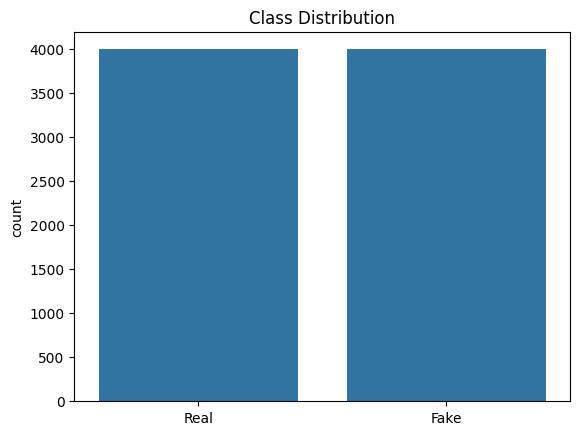

In [14]:
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Extract labels from the training set
labels = [example['label'] for example in dataset['train']]

# Plot the distribution of classes using a bar chart
sns.countplot(x=labels)                          # Create count plot of labels (0 = Real, 1 = Fake)
plt.xticks([0, 1], ['Real', 'Fake'])             # Replace 0/1 with class names for better readability
plt.title("Class Distribution")                  # Add title to the plot
plt.show()                                       # Display the plot

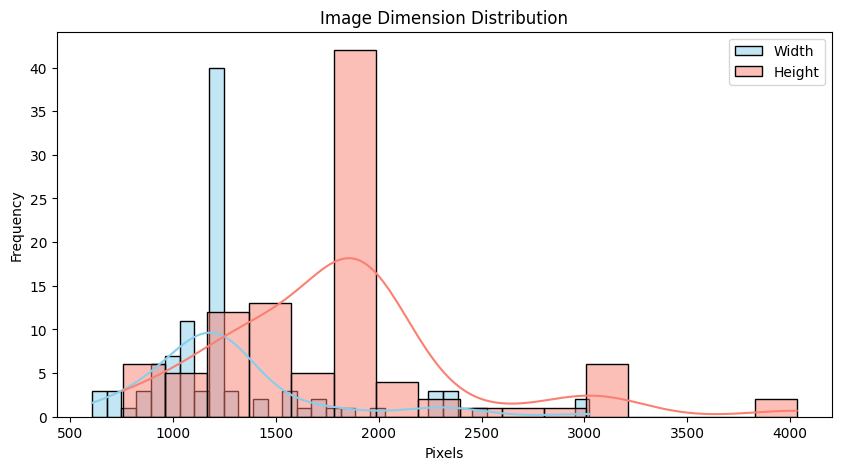

In [15]:
# Image Size Distribution

# Lists to store image dimensions
widths = []
heights = []

# Loop through the first 100 samples in the training dataset
# (Limiting to 100 to avoid long runtime)
for i in range(100):
    img = dataset['train'][i]['image']  # Load the PIL image
    w, h = img.size                     # Extract width and height
    widths.append(w)                   # Add width to list
    heights.append(h)                  # Add height to list

# Plotting the width and height distributions
plt.figure(figsize=(10,5))                            # Set plot size
sns.histplot(widths, color='skyblue', label='Width', kde=True)   # Histogram for widths
sns.histplot(heights, color='salmon', label='Height', kde=True)  # Histogram for heights
plt.legend()                                          # Show legend
plt.title("Image Dimension Distribution")             # Add plot title
plt.xlabel("Pixels")                                  # X-axis label
plt.ylabel("Frequency")                               # Y-axis label
plt.show()                                            # Display the plot

In [16]:
# RGB/Grayscale Check (Full Dataset)
rgb_count = 0
gray_count = 0

# Use the entire dataset length instead of just 100
for i in range(len(dataset['train'])):
    img = dataset['train'][i]['image']
    if img.mode == "RGB":
        rgb_count += 1
    else:
        gray_count += 1

print(f"RGB images: {rgb_count}")
print(f"Grayscale or other: {gray_count}")


RGB images: 8000
Grayscale or other: 0


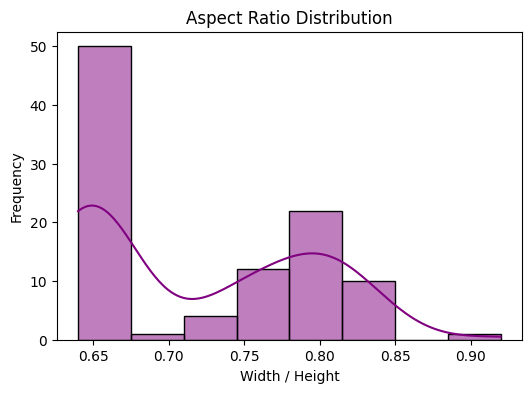

In [17]:
#Aspect Ratio Distribution
ratios = []

for i in range(100):
    w, h = dataset['train'][i]['image'].size
    ratio = round(w / h, 2)
    ratios.append(ratio)

plt.figure(figsize=(6,4))
sns.histplot(ratios, kde=True, color='purple')
plt.title("Aspect Ratio Distribution")
plt.xlabel("Width / Height")
plt.ylabel("Frequency")
plt.show()

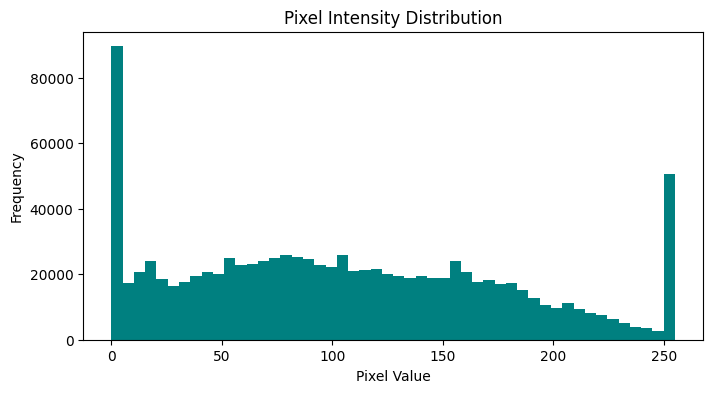

In [18]:
#Pixel Intensity Histogram
import numpy as np

pixel_values = []

for i in range(20):  # Limit to 20 images for speed
    img = dataset['train'][i]['image'].resize((128, 128))
    arr = np.array(img)
    pixel_values.extend(arr.flatten())

plt.figure(figsize=(8,4))
plt.hist(pixel_values, bins=50, color='teal')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

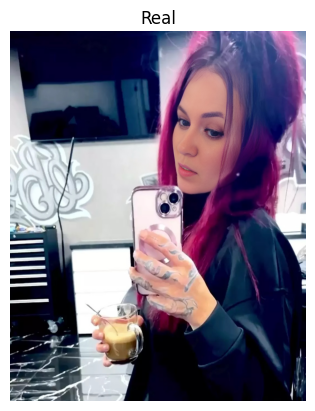

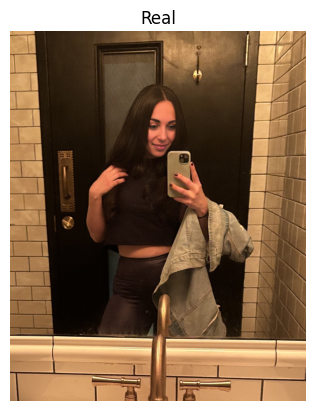

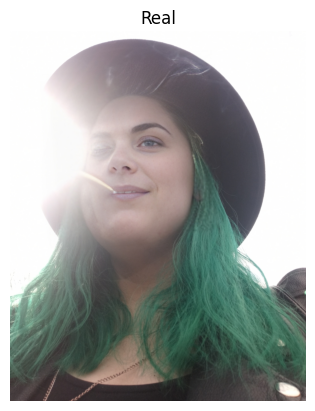

In [19]:
# Show few sample images
for i in range(3):
    image = dataset['train'][i]['image']
    label = "Fake" if dataset['train'][i]['label'] == 1 else "Real"
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
    plt.show()


Preprocessing

In [20]:
# Import necessary libraries
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define a function to preprocess each image-label pair
def preprocess(example):
    image = example['image'].resize((128, 128))                 # Resize image to 128x128
    image = tf.keras.preprocessing.image.img_to_array(image)    # Convert PIL image to NumPy array
    image = image / 255.0                                       # Normalize pixel values to range [0, 1]
    return image, example['label']                              # Return tuple of (image, label)

# Apply preprocessing to each example in the dataset
images_labels = [preprocess(example) for example in dataset['train']]  # List of (image, label) pairs

# Separate features and labels
X, y = zip(*images_labels)                 # Unzip the list of tuples into two lists
X = tf.convert_to_tensor(X)                # Convert image list to TensorFlow tensor
y = tf.convert_to_tensor(y)                # Convert label list to TensorFlow tensor

Training and testing

In [21]:
from sklearn.model_selection import train_test_split
import numpy as np

# Let's say X is a list or array of image data and y is label list
X = np.array(X)  # Make sure it's a NumPy array
y = np.array(y)  # Also convert labels to NumPy

# Then split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)

Training data shape: (6400, 128, 128, 3)
Validation data shape: (1600, 128, 128, 3)


Import model

In [22]:
from tensorflow.keras.applications import MobileNetV2

In [24]:
# Function to build a MobileNetV2-based binary classification model
def build_mobilenet_model(input_shape=(128, 128, 3)):
    # Load the pre-trained MobileNetV2 model without the top layer (head)
    # Using weights trained on ImageNet
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze the base model so its weights are not updated during training
    base_model.trainable = False

    # Build the final model
    model = models.Sequential([
        base_model,                             # Add the frozen base model
        layers.GlobalAveragePooling2D(),        # Reduce feature maps to a single vector
        layers.Dropout(0.3),                    # Add dropout for regularization
        layers.Dense(1, activation='sigmoid')   # Final output layer for binary classification
    ])

    return model  # Return the complete model

# Instantiate the model
model = build_mobilenet_model()

# Compile the model with optimizer, loss function, and evaluation metric
model.compile(
    optimizer='adam',                        # Optimizer
    loss='binary_crossentropy',              # Binary classification loss
    metrics=['accuracy']                     # Track accuracy during training and evaluation
)

In [25]:
# Function to build a MobileNetV2-based binary classifier model
def build_mobilenet_model(input_shape=(128, 128, 3)):
    # Load the MobileNetV2 model without the top layer (include_top=False)
    # Use pre-trained weights from ImageNet for feature extraction
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze the base model to avoid updating its weights during training
    base_model.trainable = False

    # Build the full model using Keras Sequential API
    model = models.Sequential([
        base_model,                             # Add the pre-trained base
        layers.GlobalAveragePooling2D(),        # Convert feature maps to a flat vector
        layers.Dropout(0.3),                    # Add dropout for regularization
        layers.Dense(1, activation='sigmoid')   # Output layer for binary classification
    ])

    return model

# Create the model instance
model = build_mobilenet_model()

# Compile the model with optimizer, loss, and evaluation metric
model.compile(
    optimizer='adam',                  # Adam optimizer for training
    loss='binary_crossentropy',        # Suitable for binary classification
    metrics=['accuracy']               # Track accuracy during training and validation
)


In [26]:
# Train the MobileNetV2 model using the training and validation sets
history = model.fit(
    X_train, y_train,               # Training data and labels
    validation_data=(X_val, y_val),# Validation data and labels for monitoring performance
    epochs=10,                      # Number of passes through the entire training set
    batch_size=32                  # Number of samples per gradient update
)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 118s 558ms/step - accuracy: 0.9067 - loss: 0.2286 - val_accuracy: 0.9869 - val_loss: 0.0487
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 103s 513ms/step - accuracy: 0.9878 - loss: 0.0456 - val_accuracy: 0.9881 - val_loss: 0.0361
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 607ms/step - accuracy: 0.9887 - loss: 0.0350 - val_accuracy: 0.9900 - val_loss: 0.0311
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 123s 510ms/step - accuracy: 0.9936 - loss: 0.0250 - val_accuracy: 0.9912 - val_loss: 0.0286
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 143s 515ms/step - accuracy: 0.9953 - loss: 0.0185 - val_accuracy: 0.9937 - val_loss: 0.0269
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 145s 528ms/step - accuracy: 0.9923 - loss: 0.0199 - val_accuracy: 0.9919 - val_loss: 0.0269
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 624ms/step - accuracy: 0.9956 - loss: 0.0154 - val_accuracy: 0.9931 - val_loss: 0.0265
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 123s 530ms/step - accuracy: 0.9947 -

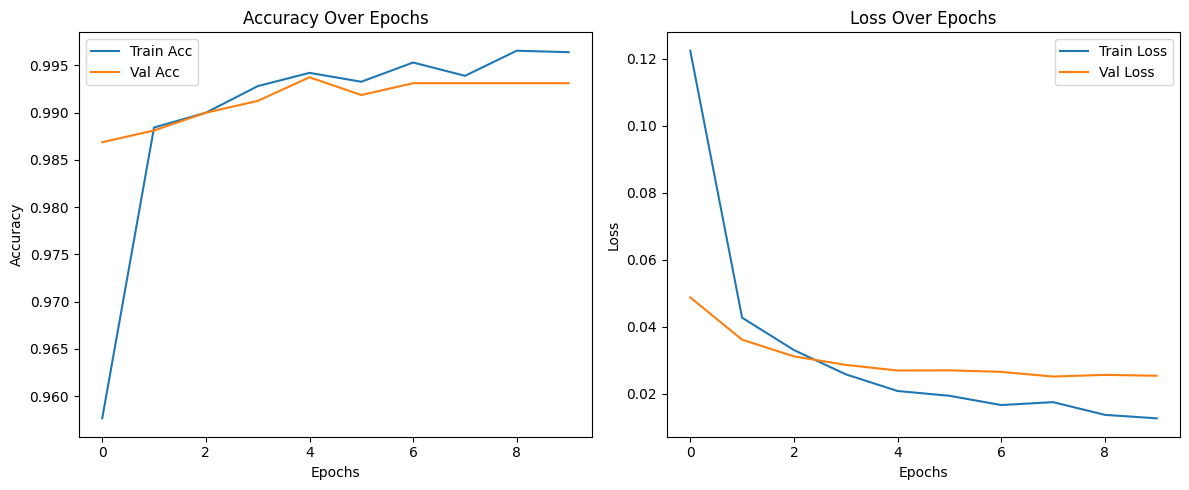

In [27]:
# Accuracy & loss curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Validation Loss: 0.0253
Validation Accuracy: 0.9931


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 447ms/step


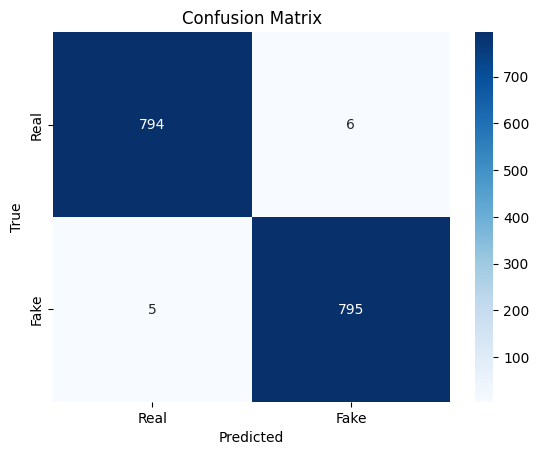

Classification Report:

              precision    recall  f1-score   support

        Real       0.99      0.99      0.99       800
        Fake       0.99      0.99      0.99       800

    accuracy                           0.99      1600
   macro avg       0.99      0.99      0.99      1600
weighted avg       0.99      0.99      0.99      1600



In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = (model.predict(X_val) > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=["Real", "Fake"]))


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 430ms/step


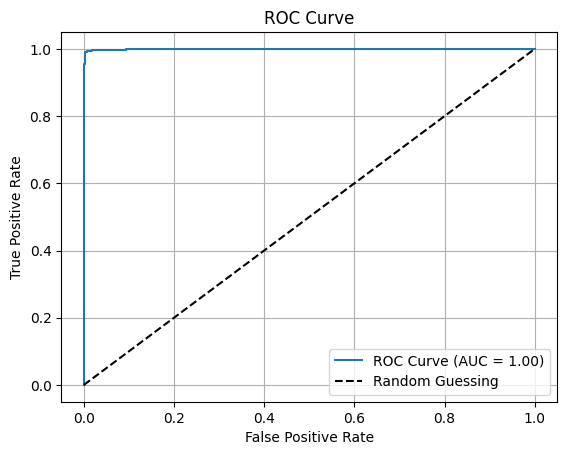

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = model.predict(X_val).ravel()
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
auc_score = roc_auc_score(y_val, y_probs)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


take input from dataset

In [45]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, log_loss, brier_score_loss

# Initialize lists to store true labels and predicted probabilities
y_true = []
y_pred_prob = []

# Number of samples to evaluate
num_samples = 50

# Check if the dataset contains the expected split and has enough samples
if 'train' not in dataset:
    raise ValueError("The dataset does not contain a 'train' split.")
elif len(dataset['train']) < num_samples:
    raise ValueError(f"The 'train' split contains only {len(dataset['train'])} samples, but {num_samples} are required.")

# Iterate over the first num_samples in the dataset
for i in range(num_samples):
    sample = dataset['train'][i]

    # Step 1: Preprocess the image
    img = sample['image'].resize((128, 128))  # Resize
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Step 2: Model prediction
    pred_prob = model.predict(img_array)[0][0]  # Probability for class 1 (Fake)

    # Step 3: Store true label and predicted probability
    y_true.append(sample['label'])
    y_pred_prob.append(pred_prob)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Step 4: Convert predicted probabilities to class labels
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Step 5: Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_class)

# Explicitly specify the labels parameter for log_loss
logloss = log_loss(y_true, y_pred_prob, labels=[0, 1])

brier = brier_score_loss(y_true, y_pred_prob)

# Print evaluation metrics
print(f"✅ Accuracy:       {accuracy:.2%}")
print(f"📉 Log Loss:       {logloss:.4f}")
print(f"🌦️ Brier Score:    {brier:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


save model in drive

In [47]:
import os

# Define the path to the 'models' directory in your Google Drive
model_dir = '/content/drive/My Drive/models'

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Define the full path for the model file
model_path = os.path.join(model_dir, 'your_model_name.h5')


In [48]:
# Assuming you're using TensorFlow/Keras
model.save(model_path)